In [1]:
import yt
import ytree
import numpy as np
from matplotlib import pylab
from yt.analysis_modules.halo_analysis.api import HaloCatalog

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Development of the HaloCatalog module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://github.com/yt-project/yt_astro_analysis for further information.
  """


In [2]:
from yt.funcs import mylog

# only critical log messages are printed
mylog.setLevel(50)

# the default log level is 20, which shows warnings and info messages
# mylog.setLevel(20)

# BH particle filters

In [3]:
@yt.particle_filter('p3_bh', ['creation_time', 'particle_mass', 'particle_type'])
def p3_bh(pfilter, data):
    return (data['particle_type'] == 1) & (data['creation_time'] > 0) & \
        (data['particle_mass'].in_units('Msun') > 1e-3)

# My thought process
- for each dataset in timeseries
    - load all field info
    - find index of BH #738543 (no radius roots) and halo #100 in each snapshot
    - use that ibh and ihl for plotting
        - create a sphere
        
- maybe one halo gets moved around, so it's at a different index, but its identifier is still the same --> that is why I should use halo INDICES of ONE HALO (follow the change of indices across snapshots) to make the spheres

# Loading data

In [4]:
ts_s = yt.load('~jw254/data/SG64-2020/GravPotential/DD????/output_????')
len(ts_s)

124

In [5]:
ts_halos_s = yt.load('~jw254/data/SG64-2020/rockstar_halos-jhw/halos_DD????.0.bin')
len(ts_halos_s) # ts_halos_s includes output_0000 which is NOT present in ts_s

125

In [6]:
ts_halos_s[1:][0] # testing

halos_DD0002.0.bin

In [7]:
# the path '~jw254' does NOT work for ytree, have to write the entire absolute path
PATH='/storage/home/hcoda1/0/jw254/data/SG64-2020/rockstar_halos-jhw/trees/'

In [8]:
ts_tree = ytree.load('/storage/home/hcoda1/0/jw254/data/SG64-2020/rockstar_halos-jhw/trees/tree_0_0_0.dat')

Performance will be improved by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("/storage/home/hcoda1/0/jw254/data/SG64-2020/rockstar_halos-jhw/trees/tree_0_0_0.dat")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)


In [9]:
fn = ts_tree.save_arbor()

Creating field arrays [1/1]: 100%|██████████| 1146033/1146033 [00:00<00:00, 26609891.47it/s]


In [10]:
ts_tree = ytree.load(fn)

In [11]:
ts_tree

arbor.h5

# Experimenting with ytree
just playing with `ytree` here, you can skip through it

In [12]:
ts_tree.size

203

In [13]:
print(ts_tree.field_list)

['scale_factor', 'uid', 'desc_scale', 'desc_uid', 'num_prog', 'pid', 'upid', 'desc_pid', 'phantom', 'sam_Mvir', 'mass', 'virial_radius', 'scale_radius', 'velocity_dispersion', 'mmp?', 'scale_of_last_MM', 'vmax', 'position_x', 'position_y', 'position_z', 'velocity_x', 'velocity_y', 'velocity_z', 'angular_momentum_x', 'angular_momentum_y', 'angular_momentum_z', 'spin_parameter', 'Breadth_first_ID', 'Depth_first_ID', 'Tree_root_ID', 'halo_id', 'Snap_idx', 'Next_coprogenitor_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'Last_mainleaf_depthfirst_ID', 'Tidal_Force', 'Tidal_ID', 'Rs_Klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'T_|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Type', 'SM', 'Gas', 'BH_Mass']


In [14]:
ts_tree[0]['position']

YTArray([0.49441324, 0.51073012, 0.49368903]) unitary

In [15]:
ts_tree['position'][0]

YTArray([0.49441324, 0.51073012, 0.49368903]) unitary

In [16]:
ts_tree[0].tree_size

1872

In [74]:
halos = list(ts_tree.select_halos("(tree['prog', 'mass'].to('Msun') < 408898) & (tree['prog', 'mass'].to('Msun') > 408890)"))

Selecting halos:   0%|          | 0/203 [00:00<?, ?it/s]

RuntimeError: Filter array and tree array sizes do not match. Make sure select_from ("tree") matches criteria ("(tree['prog', 'mass'].to('Msun') < 408898) & (tree['prog', 'mass'].to('Msun') > 408890)").

In [18]:
halos

[]

In [19]:
ts_tree[0]['position'] # last pos is [0.48960981, 0.53072717, 0.45472953]]) unitary

YTArray([0.49441324, 0.51073012, 0.49368903]) unitary

In [20]:
ts_tree[0]['prog', 'position'][0]

YTArray([0.49441324, 0.51073012, 0.49368903]) unitary

In [21]:
ts_tree[0]['prog','mass'] # 79470883.8309193 Msun # SO THE TREE TRACES BACKWARDS!!!

YTArray([79470883.8309193 , 78717114.98669818, 77992905.70499556,
         77239136.86077444, 76603606.26662724, 76041974.57877623,
         75347324.85959207, 74815252.73425952, 74460537.98403783,
         74209281.70263079, 73810227.60863139, 73425953.29589121,
         73086018.32692875, 72746083.35796629, 72332249.48270765,
         71415903.04463492, 70913390.48182085, 71268105.23204255,
         70292639.66893288, 70558675.73159917, 70130062.07508127,
         69686668.63730416, 69361513.44960093, 69051138.04315695,
         68563405.26160212, 68208690.51138042, 67853975.76115872,
         67381022.76086313, 66952409.10434525, 66509015.66656812,
         66080402.01005024, 65415311.85338456, 64898019.50931125,
         64365947.38397871, 63479160.50842447, 63360922.25835057,
         62740171.4454626 , 61986402.60124149, 61217853.97576115,
         60523204.25657699, 59828554.53739284, 58971327.22435707,
         57966302.09872893, 57094295.00443393, 56325746.37895358,
         5

In [22]:
arbor_masses = []
for tree_index in range(len(ts_tree)):
    arbor_masses.append(ts_tree[tree_index]['mass'])

In [23]:
arbor_masses # length is 203, same size as the arbor # WHY IS IT IN DESCENDING ORDER???

[79470883.8309193 Msun,
 46482412.0603015 Msun,
 31407035.175879393 Msun,
 5774460.537984037 Msun,
 3397871.7114986693 Msun,
 3281111.439550694 Msun,
 3193910.730121194 Msun,
 2819982.2642624886 Msun,
 2209577.2982559856 Msun,
 2194797.5169967483 Msun,
 2148980.1950931125 Msun,
 2035175.8793969846 Msun,
 2030741.9450192135 Msun,
 1955365.0605971029 Msun,
 1915459.651197162 Msun,
 1859296.48241206 Msun,
 1847472.6574046703 Msun,
 1752882.057345551 Msun,
 1545965.119716228 Msun,
 1545965.119716228 Msun,
 1534141.294708838 Msun,
 1523795.447827372 Msun,
 1510493.6446940582 Msun,
 1439107.3012119418 Msun,
 1391368.6077446053 Msun,
 1359739.8758498372 Msun,
 1347916.0508424474 Msun,
 1304167.8983151047 Msun,
 1250517.292344073 Msun,
 1200857.2273130356 Msun,
 1185042.8613656517 Msun,
 1145285.249778303 Msun,
 1130801.0641442505 Msun,
 1105675.436003547 Msun,
 1034141.2947088382 Msun,
 1014336.3878214601 Msun,
 980490.6887378065 Msun,
 930978.4215193614 Msun,
 913094.8861956842 Msun,
 881318

In [24]:
arbor_radii = []
for tree_index in range(len(ts_tree)):
    arbor_radii.append(ts_tree[tree_index]['virial_radius'])

In [25]:
arbor_radii # 1.1431700981478532

[13.925509902453445 kpc,
 11.644989654153118 kpc,
 10.218740762636713 kpc,
 5.8099320130062075 kpc,
 4.869937924918712 kpc,
 4.812296778007685 kpc,
 4.769435412355897 kpc,
 4.575820277859888 kpc,
 4.219627549512267 kpc,
 4.2092817026308005 kpc,
 4.179722140112326 kpc,
 4.104345255690216 kpc,
 4.1013892994383685 kpc,
 4.049660065031038 kpc,
 4.02305645876441 kpc,
 3.9831510493644693 kpc,
 3.974283180608927 kpc,
 3.904818208690511 kpc,
 3.7451965710907476 kpc,
 3.7451965710907476 kpc,
 3.7363287023352054 kpc,
 3.727460833579663 kpc,
 3.7156370085722727 kpc,
 3.656517883535324 kpc,
 3.616612474135383 kpc,
 3.588530889742832 kpc,
 3.5781850428613655 kpc,
 3.538279633461425 kpc,
 3.489506355305942 kpc,
 3.442211055276382 kpc,
 3.4274312740171444 kpc,
 3.3890038427431275 kpc,
 3.37422406148389 kpc,
 3.3490984333431864 kpc,
 3.275199527047 kpc,
 3.2545078332840673 kpc,
 3.217558380135974 kpc,
 3.162873189476796 kpc,
 3.142181495713863 kpc,
 3.10523204256577 kpc,
 3.0801064144250665 kpc,
 3.06

In [26]:
ts_tree[0]['prog', 'position'].to('pc')

YTArray([[494413.24268401, 510730.12119421, 493689.03340231],
         [494457.58202779, 510759.68075672, 493541.23558971],
         [494561.0404966 , 510818.79988176, 493393.43777712],
         [494605.37984038, 510892.69878806, 493230.86018327],
         [494664.49896542, 510937.03813184, 493097.84215194],
         [494767.95743423, 510981.37747561, 492950.04433934],
         [494797.51699675, 511143.95506946, 492861.36565179],
         [494827.07655927, 511173.51463198, 492757.90718297],
         [494930.53502808, 511232.63375702, 492610.10937038],
         [495063.55305941, 511217.85397576, 492373.63287023],
         [495137.45196571, 511262.19331954, 492255.39462016],
         [495196.57109075, 511336.09222584, 492107.59680757],
         [495285.2497783 , 511380.43156961, 491959.79899497],
         [495359.1486846 , 511454.33047591, 491812.00118238],
         [495418.26780964, 511498.66981969, 491678.98315105],
         [494960.0945906 , 512060.30150754, 492107.59680757],
        

In [27]:
ts_tree[0]['prog', 'virial_radius'].to('pc')

YTArray([13925.50990245, 13881.17055868, 13838.30919302, 13793.96984925,
         13755.54241797, 13721.54892108, 13680.16553355, 13647.65001478,
         13626.95832102, 13610.70056163, 13587.05291162, 13561.92728348,
         13542.71356784, 13520.54389595, 13495.41826781, 13437.7771209 ,
         13406.73958025, 13428.90925214, 13368.31214898, 13384.56990837,
         13356.48832397, 13328.40673958, 13307.71504582, 13287.02335205,
         13257.46378954, 13233.81613952, 13211.64646763, 13180.60892699,
         13152.5273426 , 13122.96778008, 13094.88619568, 13050.54685191,
         13016.55335501, 12981.08187999, 12920.48477683, 12913.0948862 ,
         12870.23352054, 12818.50428614, 12765.2970736 , 12718.00177357,
         12667.75051729, 12607.15341413, 12536.21046409, 12472.65740467,
         12415.01625776, 12344.07330772, 12283.47620455, 12171.14986698,
         12103.16287319, 11575.52468223, 11630.20987289, 11350.87200709,
         11002.06916938, 10741.94501921, 10564.5876

# Try plotting with ytree data
# THIS IS WHERE THINGS GO WRONG

In [46]:
hl_pos = ts_tree[0]['prog', 'position'][::-1].to('pc')
# reverse the order cuz the tree traces backwards from latest to oldest
hl_pos

YTArray([[489609.81377476, 530727.16523795, 454729.53000296],
         [491634.64380727, 530874.96305055, 456222.28791014],
         [492684.00827668, 530919.30239432, 457626.36712977],
         [492403.19243275, 530239.4324564 , 458084.5403488 ],
         [491812.00118238, 529958.61661247, 457478.56931717],
         [492092.81702631, 529869.93792492, 458040.20100503],
         [492654.44871416, 529456.10404966, 459000.88678688],
         [492329.29352646, 529101.38929944, 458276.67750517],
         [493452.55690216, 529101.38929944, 460597.10316287],
         [493910.73012119, 529130.94886196, 461631.68785102],
         [494561.0404966 , 528702.33520544, 461735.14631983],
         [494398.46290275, 528037.24504877, 462710.61188294],
         [493570.79515223, 526973.10079811, 463154.00532072],
         [493674.25362105, 526352.34998522, 463567.83919598],
         [493969.84924623, 525790.71829737, 464099.91132131],
         [494413.24268401, 525421.22376589, 464838.90038427],
        

In [47]:
hl_vr = ts_tree[0]['prog', 'virial_radius'][::-1].to('pc')
# reverse the order cuz the tree traces backwards from latest to oldest
hl_vr

YTArray([ 3189.47679574,  3440.73307715,  3683.1214898 ,  3826.48536802,
          3721.54892108,  3816.13952114,  4184.15607449,  4147.20662134,
          4537.39284659,  4677.80076855,  4810.81879988,  4968.96245936,
          5000.        ,  5029.55956252,  5156.66568135,  5598.581141  ,
          6050.84244753,  6358.26189772,  6647.9456104 ,  6639.07774165,
          6628.73189477,  7805.202483  ,  7623.41117351,  8393.43777712,
          8587.05291162,  8754.06443985,  8903.34023056,  9039.31421815,
          9216.67159326,  9370.38131836,  9596.51197162,  9757.61158735,
          9905.40939994, 10063.55305941, 10193.6151345 , 10141.88590009,
         10382.79633461, 10564.5876441 , 10741.94501921, 11002.06916938,
         11350.87200709, 11630.20987289, 11575.52468223, 12103.16287319,
         12171.14986698, 12283.47620455, 12344.07330772, 12415.01625776,
         12472.65740467, 12536.21046409, 12607.15341413, 12667.75051729,
         12718.00177357, 12765.2970736 , 12818.5042

In [50]:
# LOOP THRU EACH SNAPSHOT IN TIMESERIES
for ids in range(len(ts_s[-92:])): # just look at the last 92 snapshots
    # LOAD EACH SNAPSHOT DATASET IN TIMESERIES
    ds_s = ts_s[-92:][ids] # ts_s start from output_0002, length is 124
    ds_s.add_particle_filter('p3_bh')
    # LOAD EACH HALO DATASET IN HALOS TIMESERIES
    halos_s = ts_halos_s[1:][-92:][ids] # ts_halos_s has output_0000 which was NOT present in ts_s, start from index 1 to not include output_0000

    ###### CODE FOR EACH SNAPSHOT

    # STEP 1: GET FIELD INFO FROM EACH SNAPSHOT
    ######
    # starting STEP 1: get field info from ds
    # CONVERT everything to the same unit
    bh_id = ds_s.r['p3_bh', 'particle_index']
    bh_pos = ds_s.r['p3_bh', 'particle_position'].to('pc') # (17, 3)
    bh_vel = ds_s.r['p3_bh', 'particle_velocity'] # (17, 3)
    bh_mass = ds_s.r['p3_bh', 'particle_mass']
    #if chosen_bh_id in [int(id) for id in bh_id]:
    #    ibh = [int(id) for id in bh_id].index(chosen_bh_id)
    #if chosen_hl_id in [int(id) for id in hl_id]:
    #    ihl = [int(id) for id in hl_id].index(chosen_hl_id)
   
    ihl = ids # indexing the halos from 0 to 91

    if 2>1: # why did I write this??? not neccessary
        # create a sphere of the host halo
        sp = ds_s.sphere(hl_pos[ihl], hl_vr[ihl])

        ### plot the sphere and positions of BH and halo center, red cross is halo center, pink cross is BH

        prj = yt.ProjectionPlot(ds_s, 'x', 'density', weight_field='density', data_source=sp, center=hl_pos[ihl], width=(3,'kpc'))

        ### annotate the BH #738543
        # load bh_pos again every time because the last position vector in bh_pos gets altered after running the cell
        bh_pos = ds_s.r['p3_bh', 'particle_position'].to('pc') # (17, 3)
        prj.annotate_particles((5, 'kpc'), p_size=10, ptype='p3_bh', col='red')
        #prj.annotate_marker(bh_pos[ibh], coord_system='data', plot_args={'color':'white', 's':100}, marker = 'x')
        # white cross is where the BH is, so it's INSIDE the halo!!!

        ### annotate halos
        prj.annotate_marker([0,0], coord_system='plot', plot_args={'color':'red', 's':500}, marker = 'x')
        prj.annotate_sphere([0,0], radius=hl_vr[ihl], coord_system='plot', circle_args={'color':'green', 'linewidth':4, 'linestyle':'dashed'})

        ### timestamps & set limits for colorbar
        prj.annotate_timestamp(redshift=True) # add timestamp and redshift
        prj.set_zlim('density', zmin=1e-26, zmax=1e-23) ### set limits for colorbar

        prj.save("images_ts-ver3/")

    #ibh = 0
    #ihl = 0

Parsing Hierarchy : 100%|██████████| 401/401 [00:00<00:00, 7008.42it/s]


KeyError: ('gas', 'density')

In [33]:
ds_s.derived_field_list

[('all', 'age'),
 ('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'mesh_id'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_cylindrical_velocity_theta'),
 ('all', 'particle_cylindrical_velocity_z'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_spherical_radius'),
 ('all', 'particle_position_spherical_theta'),
 ('al

In [34]:
print(sp)

YTSphere (output_0034): , center=[1.51077803e+24 1.63765292e+24 1.40314872e+24] cm, radius=9.84169704362503e+21 cm


In [68]:
pos = ds_s.arr(hl_pos[ihl].to('pc').v, 'pc')
vr = ds_s.arr(hl_vr[ihl].to('pc').v, 'pc')

# THE SPHERE IS CAUSING THE ERROR

In [69]:
sp = ds_s.sphere(pos, vr)
yt.ProjectionPlot(ds_s, 'x', 'density', weight_field='density', data_source=sp, width=(3,'kpc'))

KeyError: ('gas', 'density')

In [70]:
sp.field_parameters

{'center': YTArray([10.92033612, 11.83742415, 10.14236066]) code_length,
 'bulk_velocity': YTArray([0., 0., 0.]) cm/s,
 'bulk_magnetic_field': YTArray([0., 0., 0.]) G,
 'normal': YTArray([0., 0., 1.]) (dimensionless),
 'radius': YTArray(0.0711386) code_length}

In [71]:
sp.radius

YTArray(0.0711386) code_length

In [66]:
sp = ds_s.sphere([0.5, 0.5, 0.5], 0.1)

/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]



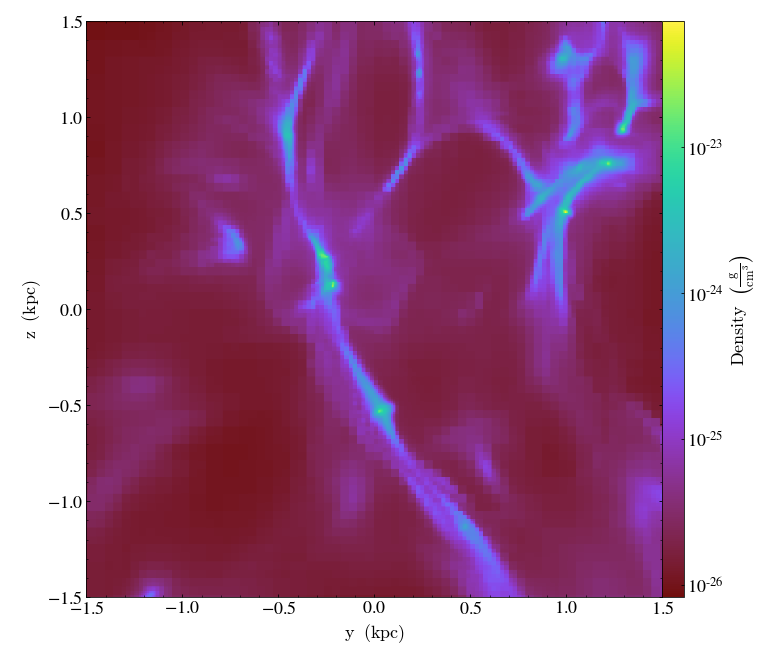

In [67]:
yt.ProjectionPlot(ds_s, 'x', 'density', weight_field='density', data_source=sp, width=(3,'kpc'))

In [56]:
hl_pos[ihl]

YTArray([489609.81377476, 530727.16523795, 454729.53000296]) pc

In [57]:
hl_vr[ihl]

3189.476795743423 pc

# DON'T MIND THE BELOW CODE

# Test with ONE DATASET

In [35]:
ds_s = ts_s[123] # ts_s start from output_0002, length is 124, last index is 123
ds_s.add_particle_filter('p3_bh')
halos_s = ts_halos_s[1:][123] # ts_halos_s has output_0000 which was NOT present in ts_s, start from index 1 to not include output_0000

Parsing Hierarchy : 100%|██████████| 777/777 [00:06<00:00, 116.89it/s]


In [36]:
# starting STEP 1: get field info from ds
# use data_ds, ad_ds, and halos_bf
# CONVERT everything to the same unit
bh_id = ds_s.r['p3_bh', 'particle_index']
bh_pos = ds_s.r['p3_bh', 'particle_position'].to('pc') # (17, 3)
bh_vel = ds_s.r['p3_bh', 'particle_velocity'] # (17, 3)
bh_mass = ds_s.r['p3_bh', 'particle_mass']
hl_pos = halos_s.r['particle_position'].to('pc') # (260, 3)
hl_vel = halos_s.r['particle_velocity'] # (260, 3)
hl_mass = halos_s.r['particle_mass']
hl_vr = halos_s.r['virial_radius'].to('pc')
hl_id = halos_s.r['particle_identifier']

In [37]:
hl_pos

YTArray([[33685.58428874, 34161.72181017, 30511.51012215],
         [33892.47451578, 34182.7087872 , 30748.17408607],
         [34434.39702569, 34888.40492971, 31929.43642982],
         [35943.25725795, 35192.87519847, 33112.70924208],
         [33980.06368611, 41361.84594969, 29999.87300613],
         [32791.52243389, 31994.85259134, 27805.38334897],
         [32679.97397518, 32007.30592505, 27837.77322608],
         [32894.80844559, 32100.13460774, 27799.53816489],
         [35853.31771976, 32956.2759891 , 27969.47337724],
         [39145.05491747, 37184.69263491, 39846.24558558],
         [33611.50430969, 40238.22908971, 30143.87462109],
         [40428.86923495, 41282.72895151, 40402.29199836],
         [40042.67486766, 41380.03779694, 40597.1664217 ],
         [39870.421831  , 41388.97642671, 40875.24386735],
         [38335.48336332, 40779.57304753, 41571.36497278],
         [39517.96789836, 41038.75715151, 41478.5724496 ],
         [40385.49229208, 40047.93969168, 39306.88678463

In [38]:
len(hl_vr)

264

In [39]:
hl_id

YTArray([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
          11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
          22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
          33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
          44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
          55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
          66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
          77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
          88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
          99., 100., 101., 102., 103., 211., 212., 213., 214., 215., 216.,
         217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227.,
         228., 229., 230., 231., 232., 104., 105., 106., 107., 108., 109.,
         110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
         121., 122., 123.

In [40]:
chosen_bh_id = 738543
if chosen_bh_id in [int(id) for id in bh_id]:
    ibh = [int(id) for id in bh_id].index(chosen_bh_id)

In [41]:
ibh

12

In [42]:
chosen_hl_id = 5
if chosen_hl_id in [int(id) for id in hl_id]:
    ihl = [int(id) for id in hl_id].index(chosen_hl_id)

In [43]:
ihl=5

In [44]:
# create a sphere of the host halo
sp = ds_s.sphere(hl_pos[ihl], hl_vr[ihl])
print(hl_vr[ihl].to('kpc'))
sample_pos = hl_pos[ihl].to('pc')
print(sample_pos)

0.19210373738723152 kpc
[32791.52243389 31994.85259134 27805.38334897] pc


/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/site-packages/yt/visualization/base_plot_types.py:258: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  interpolation='nearest', transform=transform)
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/storage/home/hcoda1/0/tnguyen747/.conda/envs/fairytienbase/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/storage/home


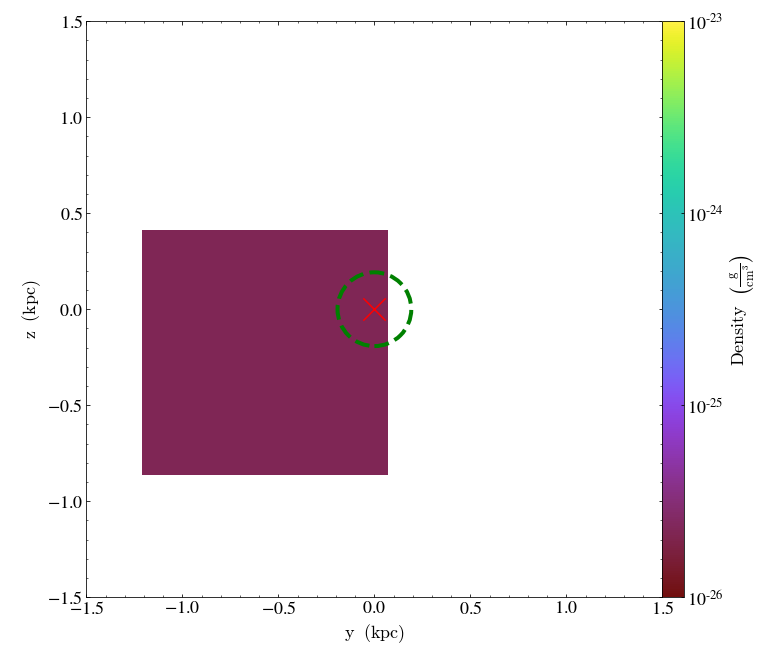

In [45]:
### plot the sphere and positions of BH and halo center, red cross is halo center, white cross is BH

prj = yt.ProjectionPlot(ds_s, 'x', 'density', weight_field='density', data_source=sp, center=hl_pos[ihl], width=(3,'kpc'))

### annotate the BH #738543
# load bh_pos again every time because the last position vector in bh_pos gets altered after running the cell
bh_pos = ds_s.r['p3_bh', 'particle_position'].to('pc') # (17, 3)
prj.annotate_particles((5, 'kpc'), p_size=10, ptype='p3_bh', col='red')
prj.annotate_marker(bh_pos[ibh], coord_system='data', plot_args={'color':'pink', 's':100}, marker = 'x')
# white cross is where the BH is, so it's INSIDE the halo!!!

### annotate halos
prj.annotate_marker([0,0], coord_system='plot', plot_args={'color':'red', 's':500}, marker = 'x')
prj.annotate_sphere([0,0], radius=hl_vr[ihl], coord_system='plot', circle_args={'color':'green', 'linewidth':4, 'linestyle':'dashed'})

### timestamps & set limits for colorbar
prj.annotate_timestamp(redshift=True) # add timestamp and redshift
prj.set_zlim('density', zmin=1e-26, zmax=1e-23) ### set limits for colorbar

prj

# the problem is that I run the cell twice. DON'T run it twice (OR multiple similar cells)!!! will mess up the positions regardless of hl_pos or halos_pos
# the actual fix is that don't use halos_pos[ihl] or hl_pos[ihl] for position of annotate_marker or annotate_sphere, use [0,0] and coord_system='plot' instead

# Reference the BH_halo_match

In [103]:
import pickle
with open('../project_BH_orbit_characteristics/data_sp_avg_ts-ver1/sp_avg_bh_hl_match_ts.pkl', 'rb') as file:
    bh_hl_match_ts = pickle.load(file)

bh_hl_match_ts # contains a match of BH and halo INDICES

{0: {},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 11: {},
 12: {},
 13: {},
 14: {},
 15: {},
 16: {},
 17: {},
 18: {},
 19: {},
 20: {},
 21: {},
 22: {},
 23: {},
 24: {},
 25: {},
 26: {},
 27: {},
 28: {},
 29: {},
 30: {},
 31: {0: 9},
 32: {0: 6, 1: 44},
 33: {0: 4, 1: 49},
 34: {0: 3, 1: 48, 2: 13},
 35: {0: 4, 1: 4, 2: 56, 3: 35, 4: 18},
 36: {0: 6, 1: 6, 2: 63, 3: 38, 4: 36, 5: 27},
 37: {0: 5, 1: 5, 2: 56, 3: 29, 4: 35, 6: 20, 7: 20, 8: 20},
 38: {0: 5, 1: 5, 2: 64, 3: 38, 4: 35, 5: 22, 6: 24, 7: 24, 8: 24},
 39: {0: 14,
  1: 14,
  2: 72,
  3: 71,
  4: 49,
  5: 48,
  6: 52,
  7: 9,
  8: 35,
  9: 30,
  10: 30,
  11: 30},
 40: {0: 8,
  1: 8,
  2: 79,
  3: 79,
  4: 51,
  5: 51,
  6: 5,
  7: 31,
  8: 31,
  9: 31,
  10: 28,
  11: 45},
 41: {0: 13,
  1: 12,
  2: 12,
  3: 82,
  4: 82,
  5: 79,
  6: 49,
  7: 49,
  8: 31,
  9: 31,
  10: 31,
  11: 36,
  12: 45,
  13: 7},
 42: {0: 15,
  1: 22,
  2: 22,
  3: 84,
  4: 84,
  5: 93,
  6: 59,
  7: 59,